<a href="https://colab.research.google.com/github/harimshin/data-science-portfolio/blob/main/machine_learning_binary_classification_with_SMOTE_prediction_model_for_the_severity_of_car_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Model to Predict the Severity of the Car Accidents**

# **I. Data Preparation**

In [1]:
# install pyspark
%%bash
pip install pyspark

# get data file
data_file=US_Accidents_Dec21_updated.csv
if [[ ! -f ./${data_file} ]]; then
   # download the data file from github and save it in this colab environment instance
   wget https://media.githubusercontent.com/media/harimshin/public_dataset/main/${data_file} &>/dev/null
fi

# Original source of dataset: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents

In [2]:
# create spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "32g").getOrCreate()

# **II. Data Collection & Cleaning**

In [3]:
# import car accidents dataset into a pyspark dataframe
df = spark.read.option("header",True).csv("US_Accidents_Dec21_updated.csv")

from pyspark.sql.functions import count

# print the shape of the dataframe
print("Number of rows in the dataframe: ", df.count())
print("Number of columns in the dataframe: ", len(df.columns))

Number of rows in the dataframe:  2845342
Number of columns in the dataframe:  47


In [4]:
# display the variables for each category (time/location, weather, traffic, day/night)
df.select(df.columns[:9]).printSchema()
df.select(df.columns[:9]).show(5)
df.select(df.columns[9:20]).printSchema()
df.select(df.columns[9:20]).show(5)
df.select(df.columns[20:30]).printSchema()
df.select(df.columns[20:30]).show(5)
df.select(df.columns[30:43]).printSchema()
df.select(df.columns[30:43]).show(5)
df.select(df.columns[43:47]).printSchema()
df.select(df.columns[43:47]).show(5)

root
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)

+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|
+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+
|A-1|       3|2016-02-08 00:37:08|2016-02-08 06:37:08|40.108909999999995|         -83.09286|          40.11206|         -83.03187|               3.23|
|A-2|       2|2016-02-08 05:56

In [5]:
# drop the columns not necessary for the analysis
drop_cols = ('Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'City', 'County', 'Airport_Code', 'Description', 'Number', 'Street', 'Zipcode', 'Country', 'Weather_Timestamp', 'Weather_Condition')
df2 = df.drop(*drop_cols)

# delete rows with any null/NA column
car_acc = df2.na.drop()
print("Number of rows in the dataframe: ", car_acc.count())
print("Number of columns in the dataframe: ", len(car_acc.columns))

Number of rows in the dataframe:  2212394
Number of columns in the dataframe:  31


In [6]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import FloatType, BooleanType

# convert the data types into the new data type which can be more appropriate for the analysis
# group severity degree 1 & 2 into 0 (non-severe) and 3 & 4 into 1 (severe)
car_acc2 = car_acc.\
  withColumn("Severity", when(car_acc.Severity < 3, 0).when(car_acc.Severity >= 3, 1)).\
  withColumn("Distance(mi)", col("Distance(mi)").cast(FloatType())).\
  withColumn("Temperature(F)", col("Temperature(F)").cast(FloatType())).\
  withColumn("Wind_Chill(F)", col("Wind_Chill(F)").cast(FloatType())).\
  withColumn("Humidity(%)", col("Humidity(%)").cast(FloatType())).\
  withColumn("Pressure(in)", col("Pressure(in)").cast(FloatType())).\
  withColumn("Visibility(mi)", col("Visibility(mi)").cast(FloatType())).\
  withColumn("Wind_Direction", when(car_acc.Wind_Direction == 'North', "N").when(car_acc.Wind_Direction == "South", "S").\
             when(car_acc.Wind_Direction == "East", "E").when(car_acc.Wind_Direction == "West", "W"). when(car_acc.Wind_Direction ==  "Variable", "VAR").otherwise(car_acc.Wind_Direction)).\
  withColumn("Wind_Speed(mph)", col("Wind_Speed(mph)").cast(FloatType())).\
  withColumn("Precipitation(in)", col("Precipitation(in)").cast(FloatType()))
  # withColumn("Amenity", col("Amenity").cast(BooleanType())).\
  # withColumn("Bump", col("Bump").cast(BooleanType())).\
  # withColumn("Crossing", col("Crossing").cast(BooleanType())).\
  # withColumn("Give_Way", col("Give_Way").cast(BooleanType())).\
  # withColumn("Junction", col("Junction").cast(BooleanType())).\
  # withColumn("No_Exit", col("No_Exit").cast(BooleanType())).\
  # withColumn("Railway", col("Railway").cast(BooleanType())).\
  # withColumn("Roundabout", col("Roundabout").cast(BooleanType())).\
  # withColumn("Station", col("Station").cast(BooleanType())).\
  # withColumn("Stop", col("Stop").cast(BooleanType())).\
  # withColumn("Traffic_Calming", col("Traffic_Calming").cast(BooleanType())).\
  # withColumn("Traffic_Signal", col("Traffic_Signal").cast(BooleanType())).\
  # withColumn("Turning_Loop", col("Turning_Loop").cast(BooleanType()))


In [7]:
# print schema of newly transformed variables
car_acc2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Distance(mi): float (nullable = true)
 |-- Side: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Temperature(F): float (nullable = true)
 |-- Wind_Chill(F): float (nullable = true)
 |-- Humidity(%): float (nullable = true)
 |-- Pressure(in): float (nullable = true)
 |-- Visibility(mi): float (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): float (nullable = true)
 |-- Precipitation(in): float (nullable = true)
 |-- Amenity: string (nullable = true)
 |-- Bump: string (nullable = true)
 |-- Crossing: string (nullable = true)
 |-- Give_Way: string (nullable = true)
 |-- Junction: string (nullable = true)
 |-- No_Exit: string (nullable = true)
 |-- Railway: string (nullable = true)
 |-- Roundabout: string (nullable = true)
 |-- Station: string (nullable = true)
 |-- Stop: string (nullable = true)
 |-- Traffic_Ca

In [8]:
car_acc2.show(10)

+----+--------+------------+----+-----+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|Severity|Distance(mi)|Side|State|  Timezone|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+----+--------+------------+----+-----+----------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+----

# **III. Data Exploration & Insights**

**1. The relationship between the state and the car accidents severity**

In [9]:
pip install chart_studio

In [10]:
from random import sample

# sample the large dataset (5%)
car_acc3 = car_acc2.sample(0.05)

# create a pandas df for EDA
car_acc3_pd = car_acc3.toPandas()

In [11]:
import pandas as pd

import matplotlib.pyplot as plt
from chart_studio import plotly
import plotly.graph_objects as go

from pyspark.sql.functions import round

# summarize the count of the severity by state
acc_state = car_acc2[['Severity', 'State']]
acc_state_crosstab = acc_state.crosstab('State', 'Severity').orderBy('State_Severity')
acc_state_crosstab_prob = acc_state_crosstab.withColumn("prob_0", round(col("0") / (col("0") + col("1")), 2)).\
                                              withColumn("prob_1", round(col("1") / (col("0") + col("1")), 2)).\
                                              withColumnRenamed('State_Severity', 'State')
# convert the spark df to pandas df
acc_state_crosstab_prob_pd = acc_state_crosstab_prob.toPandas()

# visualize the probability that an accident is severe in the state
fig = go.Figure(
    data=go.Choropleth(
        locations = acc_state_crosstab_prob_pd['State'],
        z = acc_state_crosstab_prob_pd['prob_1'].astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = "Probability",
))

fig.update_layout(
    title_text = 'Severe Car Accident Probability by State',
    geo_scope='usa',
)

fig.show()

With the modified severity variable, I calculated the probability of an accident to be ‘severe’, and plotted the probability on the US state map.
We can see that in Colorado, Wisconsin, and Illinois, almost 50% percent of car accidents are severe.  


**2. Number of car accidents by severity group**
In our original data, we can verify that accidents with severity degree 2 is most common. Thus, I decided to convert the target variable into dummy variable indicating if the accident is severe or not. I categorized the accident with severity degree less or equal to 2 as 0 which means “not severe accidents”, and the accidents with severity degree greater than 2 as 1 which means “severe accidents".

In [12]:
from pyspark.sql.functions import  asc

# distribution of the target variable(the severity of the car accidents)
car_acc.groupBy("Severity").count().orderBy(col('Severity').asc()).show()

+--------+-------+
|Severity|  count|
+--------+-------+
|       1|  23593|
|       2|2061892|
|       3|  64643|
|       4|  62266|
+--------+-------+



We can see that roughly 89% of data are categorized as 1 or 2, only 11% are categorized as 3 or 4

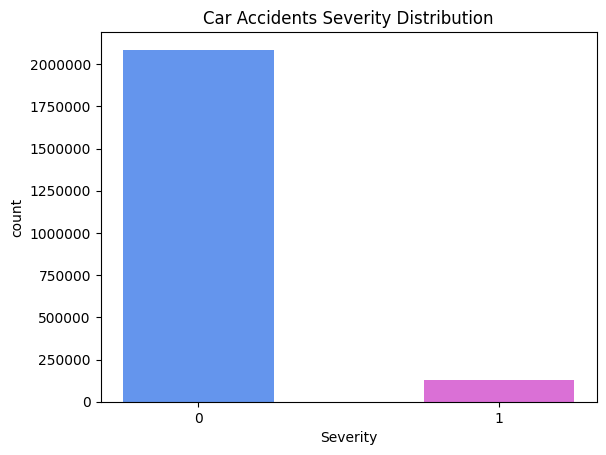

In [13]:
import numpy as np
import seaborn as sns

# visualize the the count of severity group
severity_dist = car_acc2.groupby('Severity').count().orderBy(col('Severity').asc()).toPandas()
plt.bar(severity_dist['Severity'], severity_dist['count'], width = 0.5, color = ['cornflowerblue', 'orchid'])
plt.xticks([0,1])
plt.xlabel('Severity')
plt.ylabel('count')
plt.title('Car Accidents Severity Distribution')
plt.ticklabel_format(scilimits=(0, 20))

We can observe only 11% of our data points are in the minority class (Severity = 1). This imbalanced data prevent the model to effectively learn the decision boundary. To solve this problem, I use Synthetic Minority Oversampling Technique (SMOTE), which is the most prevantly used approach to synthesize new examples from the minority class. I will use the new balanced dataset in the later section.

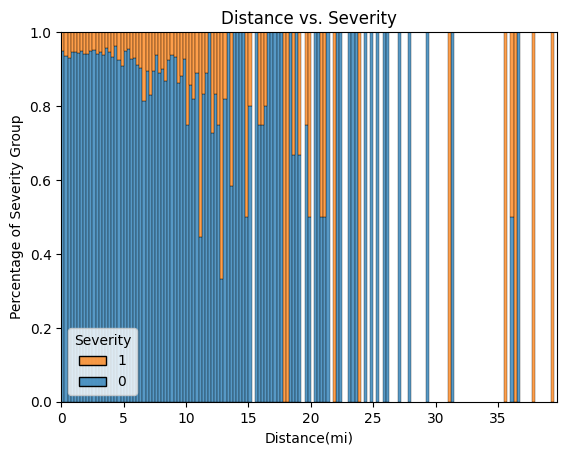

In [14]:
# visualized the relationship between distance and severity level
distance_df = car_acc3_pd[['Severity','Distance(mi)']]
sns.histplot(data=distance_df, x='Distance(mi)', hue='Severity', multiple = "fill", bins = np.arange(0, 40, 0.25), hue_order = [1, 0], palette = ['#ff7f0e', '#1f77b4'])
plt.xlabel('Distance(mi)')
plt.ylabel('Percentage of Severity Group')
plt.title('Distance vs. Severity')
plt.show()

We can see that if the distance between start point and end point of the accident, the severity of it increases. However, distance can be measured only after the accident happens, I did not include this for the model.

Text(0.5, 1.0, 'Side vs. Severity')

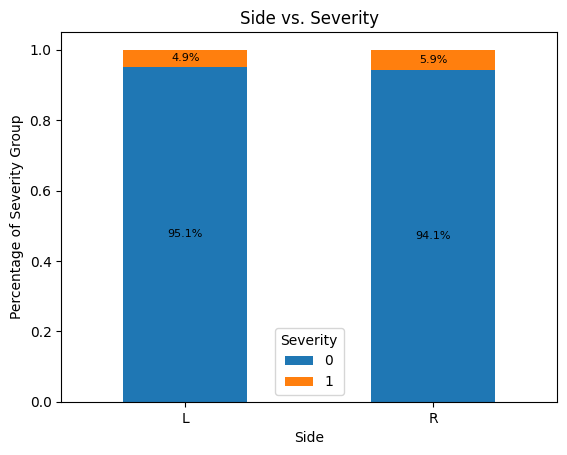

In [15]:
# visualize the relationship between side and severity level
side = pd.crosstab(car_acc3_pd['Side'], car_acc3_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
side_bar = side.plot(kind="bar", stacked=True, rot=0, width = 0.5, ylabel = 'Side')
for bars in side_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      side_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
side_bar.set_ylabel('Percentage of Severity Group')
side_bar.set_title("Side vs. Severity")

We can verify that the car accidents in the right lane is more severe than those in the left lane.

Text(0.5, 1.0, 'Timezone vs. Severity')

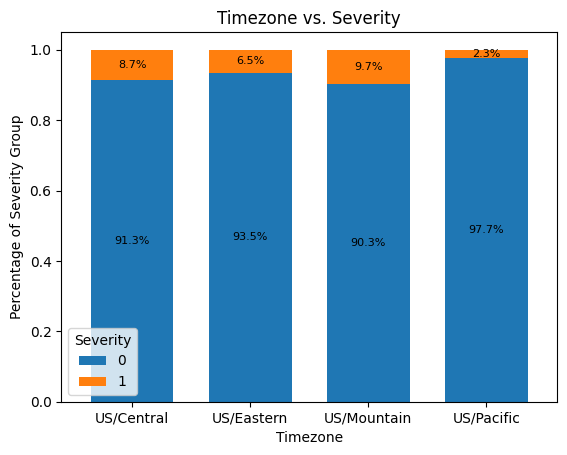

In [16]:
# visualize the relationship between timezone and severity level
timezone = pd.crosstab(car_acc3_pd['Timezone'], car_acc3_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
timezone_bar = timezone.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Timezone')
for bars in timezone_bar.containers:
    heights = [b.get_height() for b in bars]
    labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
    timezone_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 8)
timezone_bar.set_ylabel('Percentage of Severity Group')
timezone_bar.set_title("Timezone vs. Severity")

We can verify that the car accidents in central or mountain time zone are more severe than those in eastern or pacific time zone.

**3-1. Weather-related features: correlation**

Text(0.5, 1.0, 'Weather Features Correlation Heatmap')

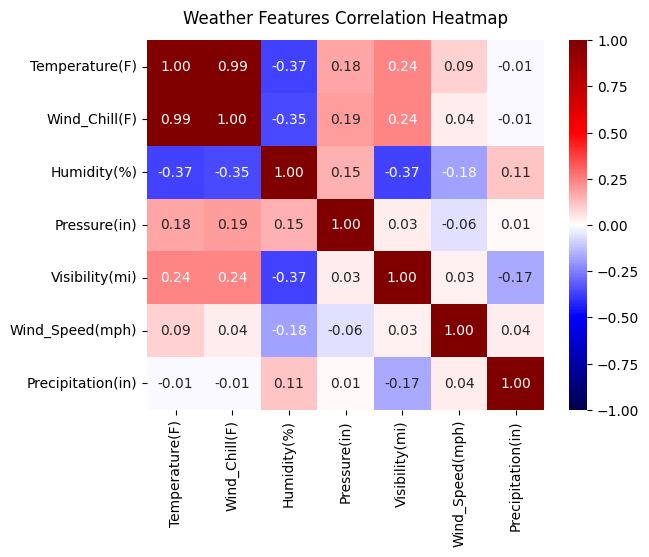

In [17]:
# visualize the correlation between weather-related features
weather_list=['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
weather_df = car_acc3_pd[weather_list]
weather_corr = sns.heatmap(weather_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
weather_corr.set_title('Weather Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

From the correlation heat map, we can see that temperature and wind_chill are highly correlated(0.99).

**3-2. Weather-related features: bar plots**

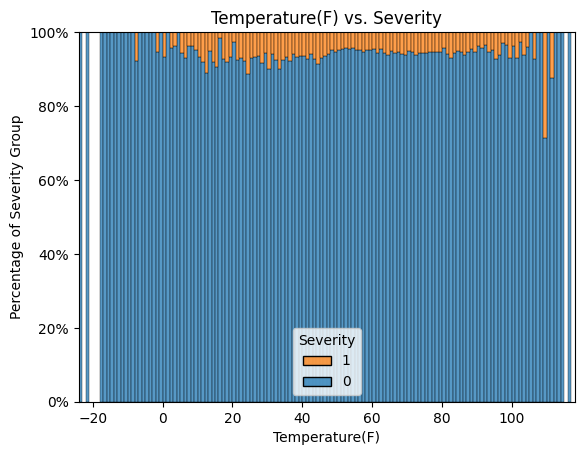

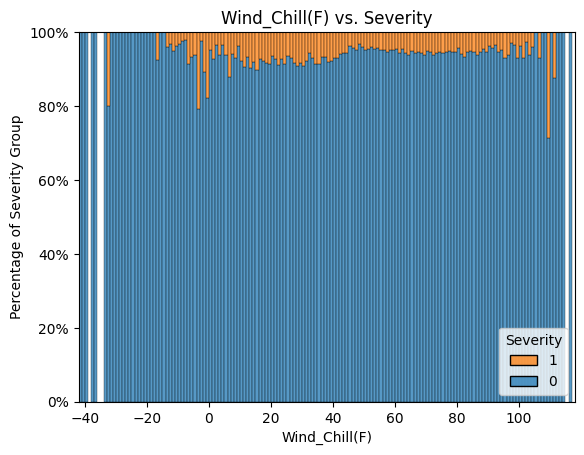

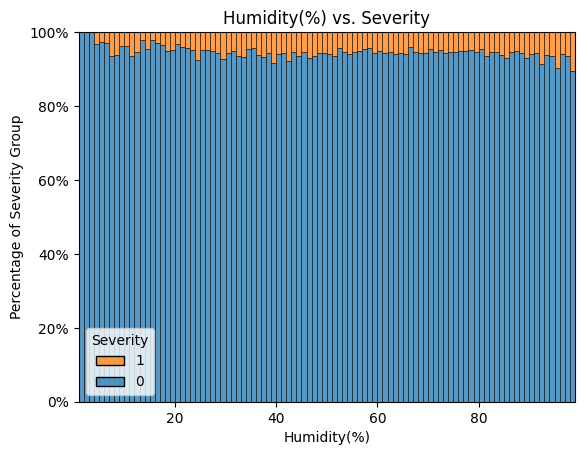

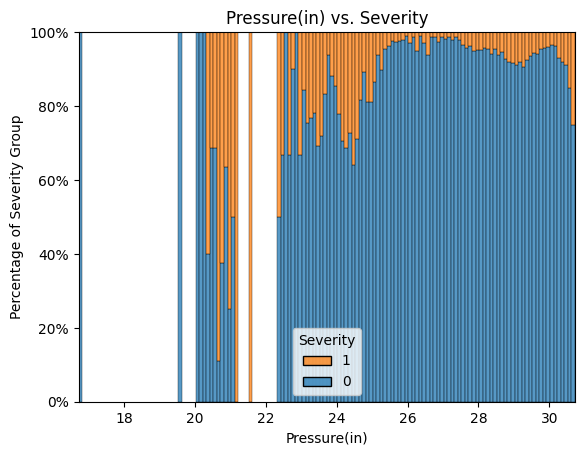

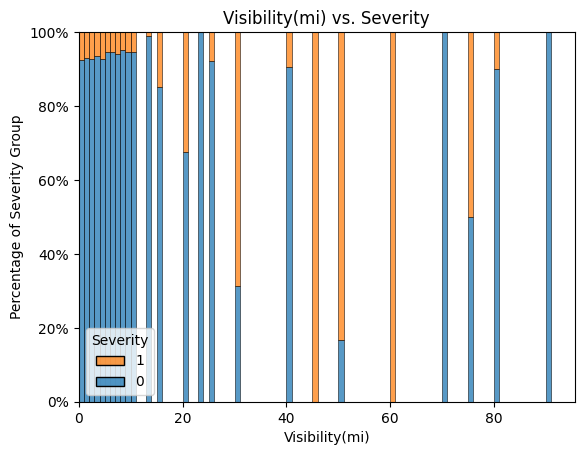

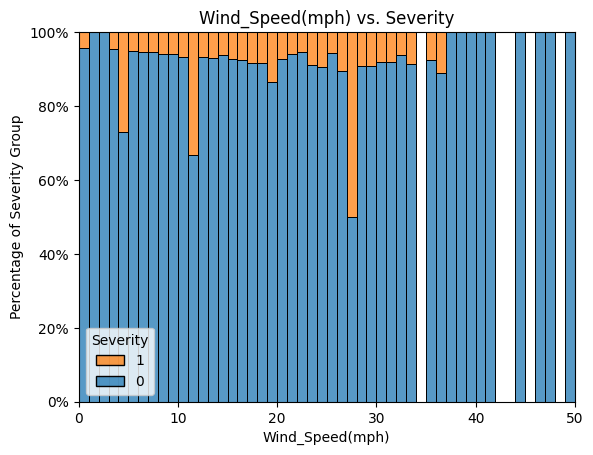

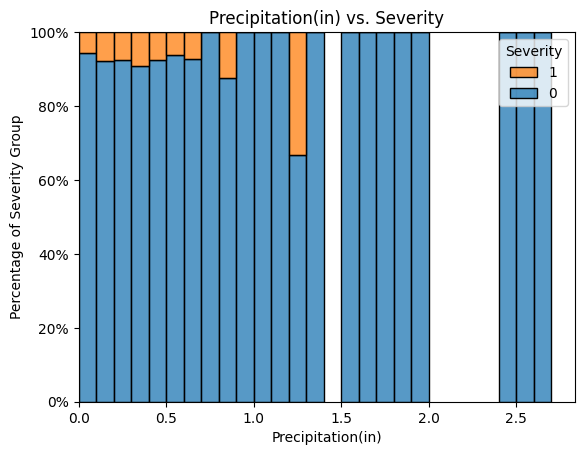

In [18]:
from matplotlib.ticker import PercentFormatter

# visualize the relationship between weather-related features and severity level
weather_severity_list = ['Severity','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
weather_severity_df = car_acc3_pd[weather_severity_list]

for i in range(len(weather_list)):

  diff = max(weather_severity_df[weather_list[i]]) - min(weather_severity_df[weather_list[i]])
  if diff >= 50: width = 1
  elif diff >= 20: width = 0.5
  else: width = 0.1

  min_val = min(weather_severity_df[weather_list[i]])
  max_val = max(weather_severity_df[weather_list[i]])

  ax = sns.histplot(
      data=weather_severity_df,
      x=weather_list[i],
      hue='Severity',
      multiple='fill',
      bins=np.arange(min_val, max_val, width),
      hue_order = [1, 0],
      palette = ['#ff7f0e', '#1f77b4']
      )

  ax.yaxis.set_major_formatter(PercentFormatter(1))
  ax.set_ylabel('Percentage of Severity Group')
  ax.set_title(weather_list[i] + " vs. Severity")
  plt.show()

The box plots from the weather-related features show that see the conditions of pressure and wind speed when a car accident happened can be good features to predict the severity of the car accidents.
Plots show that the car accidents in very low or very high temperature(wind chill) are more severe than others.
Also, we can find that low humidity, low pressure, and low visibility causes the car accidents to be severe.

Text(0.5, 1.0, 'Wind Direction vs. Severity')

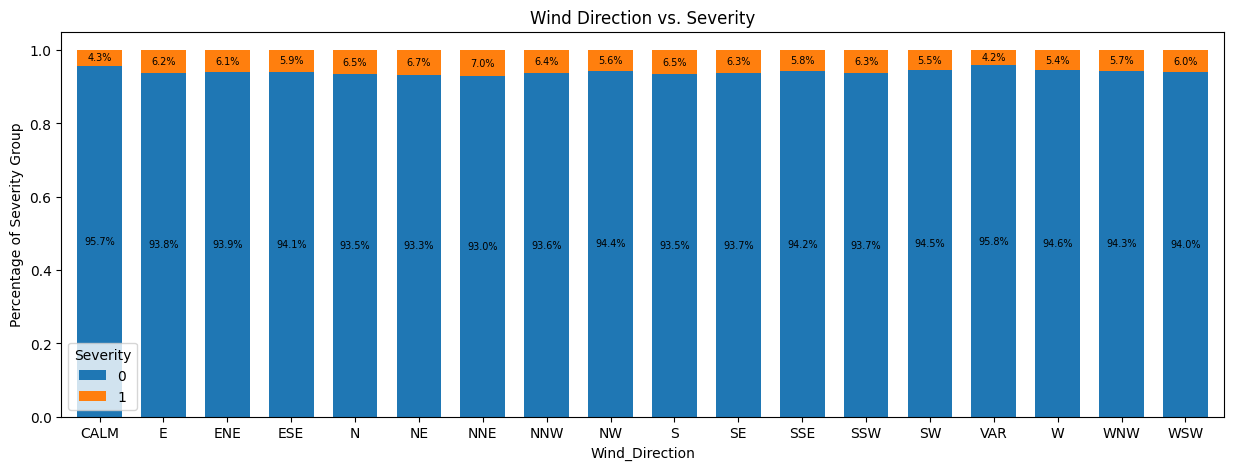

In [19]:
# visualize the relationship between wind direction and severity level
wind_dir = pd.crosstab(car_acc3_pd['Wind_Direction'], car_acc3_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
wind_dir_bar = wind_dir.plot(kind="bar", stacked=True, rot=0, width = 0.7, ylabel = 'Wind_Direction',figsize=(15, 5))
for bars in wind_dir_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      wind_dir_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)
wind_dir_bar.set_ylabel('Percentage of Severity Group')
wind_dir_bar.set_title("Wind Direction vs. Severity")

**4-1. Traffic-related features: correlation heatmap**


In [20]:
# create a list of features related to traffic
traffic_list = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

Text(0.5, 1.0, 'Traffic Features Correlation Heatmap')

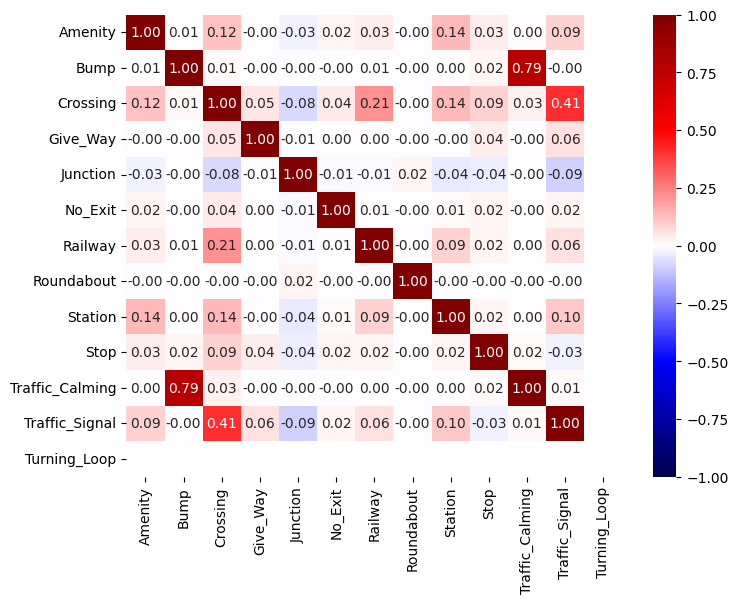

In [21]:
traffic_df = car_acc3_pd[traffic_list].astype('category')

for feature in traffic_list:
  traffic_df[feature] = traffic_df[feature].replace({'False' : 0, "True" : 1})

plt.figure(figsize=(8, 6))
traffic_corr = sns.heatmap(traffic_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
weather_corr.set_title('Traffic Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

We can verify that Bump and Traffic Calming, Crossing and Traffic Signal have high correlation.

**4-2. Traffic-related features: bar plots**

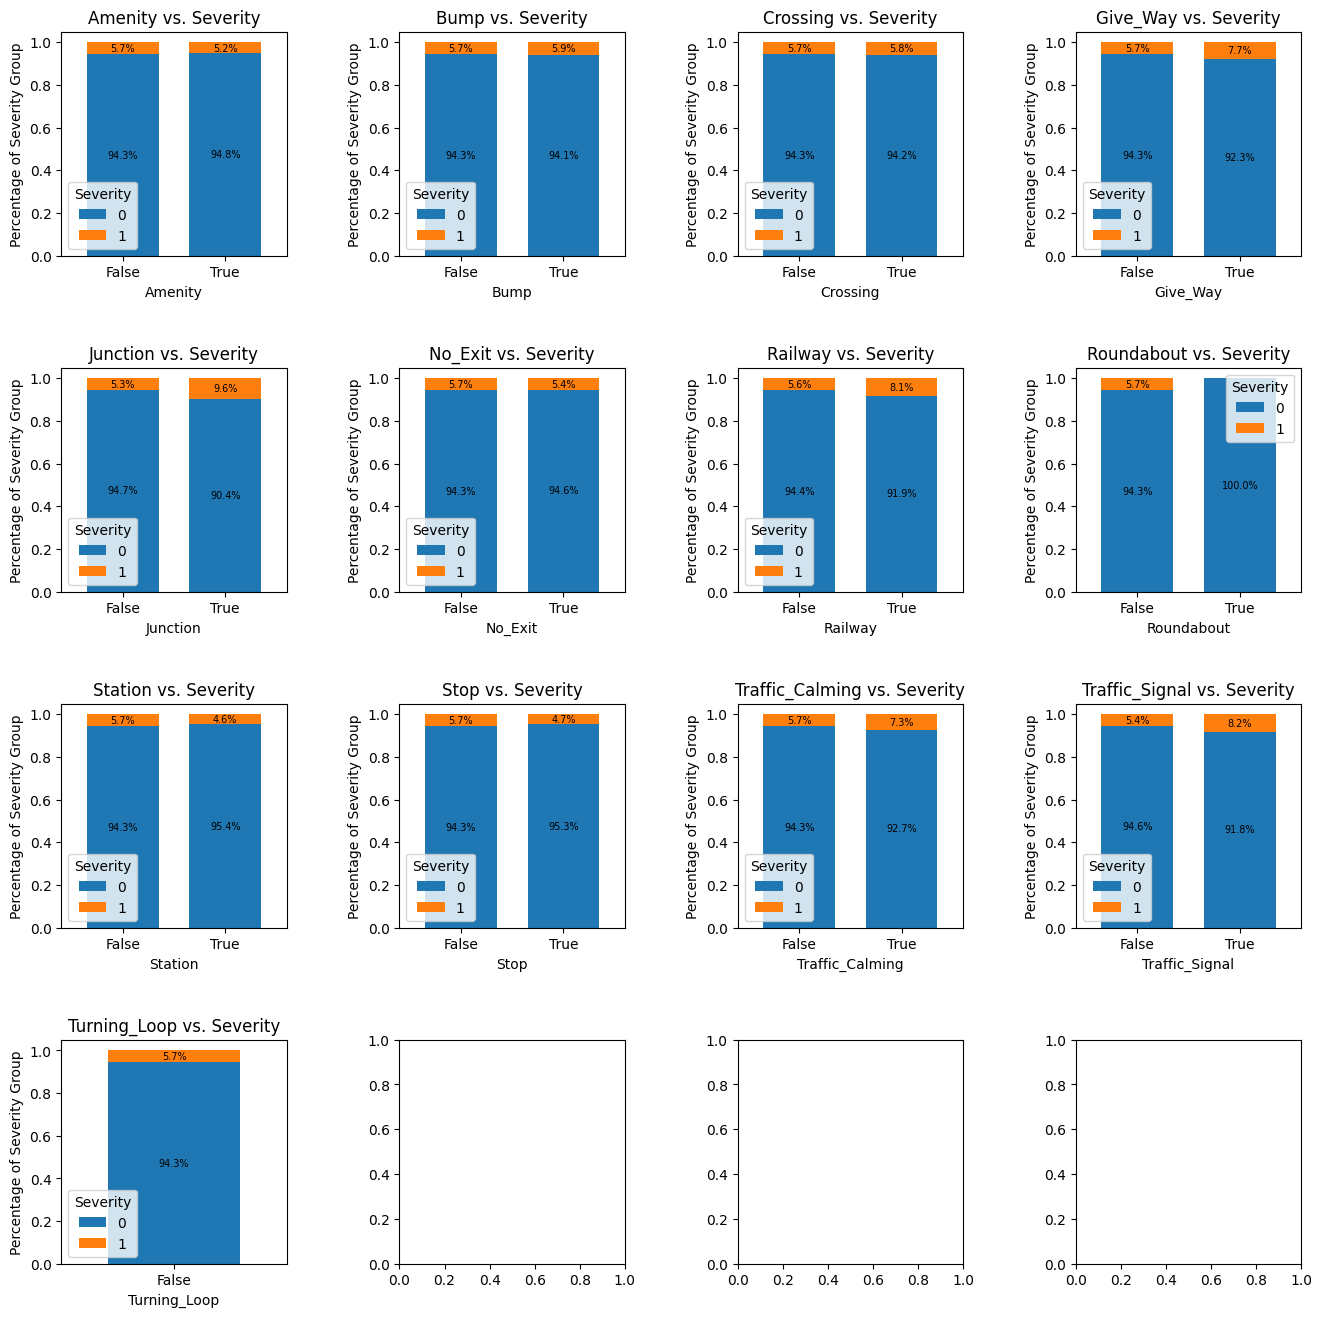

In [22]:
# visualize the relationship between traffic condition and severity level
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(len(traffic_list)):
  ct = pd.crosstab(car_acc3_pd[traffic_list[i]], car_acc3_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
  ct_bar = ct.plot(ax=axes[i//4, i%4], kind="bar", stacked=True, rot=0, width = 0.7, ylabel = traffic_list[i])

  for bars in ct_bar.containers:
      heights = [b.get_height() for b in bars]
      labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
      ct_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)

  ct_bar.set_ylabel('Percentage of Severity Group')
  ct_bar.set_title(traffic_list[i] + " vs. Severity")

The bar plots from the traffic-related features show that see whether there is a junction or crossing happened can be good features to predict the severity of the car accidents.

**5-1. Sunlight-related features: correlation**

In [23]:
# create a list of features related to sunlight
sunlight_list = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

Text(0.5, 1.0, 'Sunlight Features Correlation Heatmap')

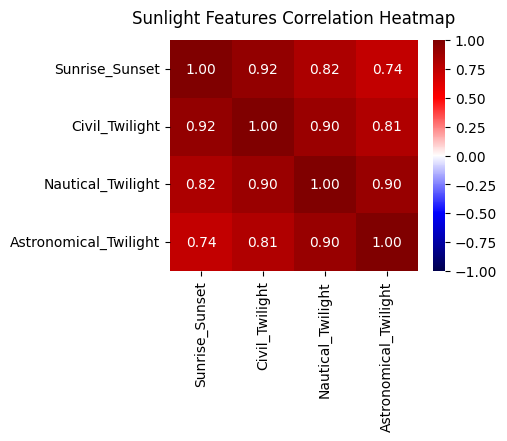

In [24]:
sunlight_df = car_acc3_pd[sunlight_list].astype('category')

for feature in sunlight_list:
  sunlight_df[feature] = sunlight_df[feature].replace({'Day' : 0, "Night" : 1})

plt.figure(figsize=(4, 3))
sunlight_corr = sns.heatmap(sunlight_df.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
sunlight_corr.set_title('Sunlight Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

We can verify the sunlight-related features are highly correlated (> 0.70)

**3-3. Sunlight-related features**

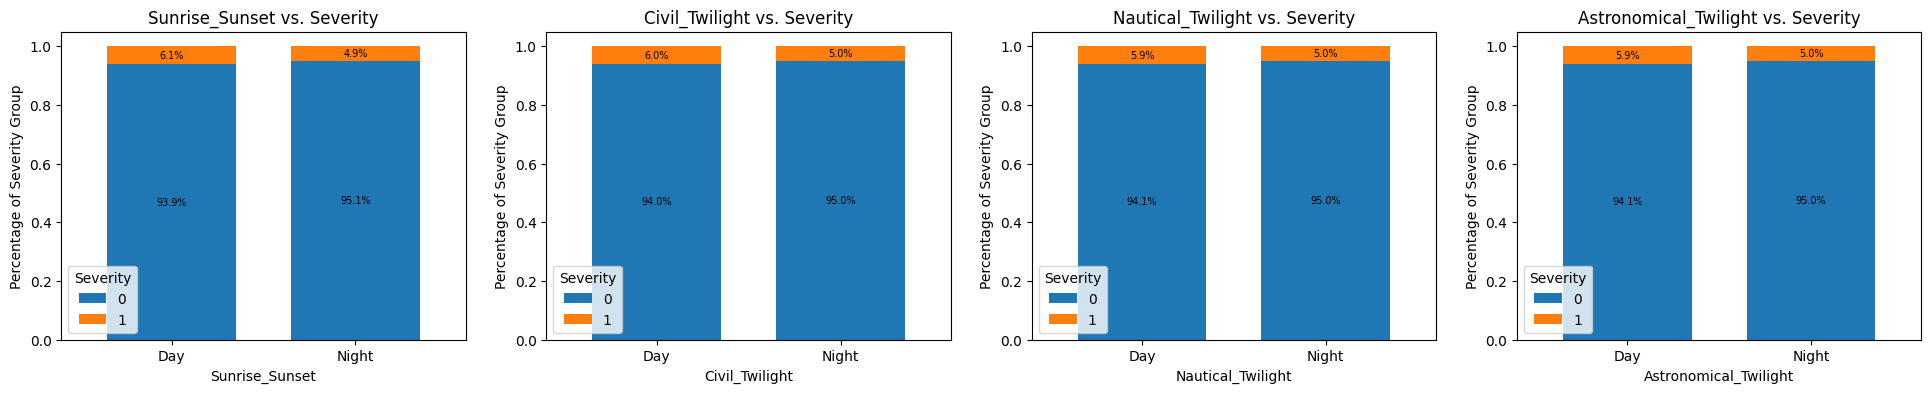

In [25]:
# visualize the relationship between sunlight condition and severity level
fig, axes = plt.subplots(1,4, figsize = (24,4))

for i in range(len(sunlight_list)):
 ct = pd.crosstab(car_acc3_pd[sunlight_list[i]], car_acc3_pd['Severity']).apply(lambda r: r/r.sum(), axis=1)
 ct_bar = ct.plot(ax=axes[i], kind = "bar", stacked = True, rot=0, width = 0.7, ylabel = 'Severity')

 for bars in ct_bar.containers:
  heights = [b.get_height() for b in bars]
  labels = [f'{h * 100:.1f}%' if h > 0.001 else '' for h in heights]
  ct_bar.bar_label(bars, labels=labels, label_type='center', fontsize = 7)

  ct_bar.set_ylabel('Percentage of Severity Group')
  ct_bar.set_title(sunlight_list[i] + " vs. Severity")

The bar plots from the sunlight-related features show that there not so much difference between two conditions, day and night, in predicting car accidents severity.

# **IV. Model Predictions**

For the binary classification task (Severity = 0 or 1), I used multiple models for the task such as logistic regression, SVM, random forest, and gradient boosting and compared their performance. Before running the models, I conducted Synthesized Minority Oversampling Technique (SMOTE) to deal with the issue of imbalance in our dataset.

**Synthetic Minority Oversampling Technique (SMOTE)**

In [26]:
# rename "Severity" variable to "label" for convenience in the further steps
# use the sampled data (5%) to run the models with given resources
imbalanced_df = car_acc3.withColumnRenamed("Severity", "label")

# split the data into training data, validation data, and testing data
training_df, validation_df, testing_df = imbalanced_df.randomSplit([0.6, 0.2, 0.2])

# convert the spark df to pandas df
imbalanced_training_pd = training_df.toPandas()

# create the lists of categorical features for SMOTE
categoricalCols = ['Side', 'State', 'Timezone', 'Wind_Direction']
categorical_features = traffic_list + sunlight_list + categoricalCols

# convert the type of categorical features from object to category
for feature in categorical_features:
  imbalanced_training_pd[feature] = imbalanced_training_pd[feature].astype('category')

In [27]:
pip install imbalanced-learn

In [28]:
from imblearn.over_sampling import SMOTENC

# separate features and labels
X = imbalanced_training_pd.drop(['ID', 'label'], axis=1)  # Features (excluding the label column)
y = imbalanced_training_pd['label']  # Label (target variable)

# initialize the SMOTE object
smote_nc = SMOTENC(categorical_features = categorical_features, random_state = 42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# convert the resampled data to a spark df
resampled_final = pd.concat([y_resampled, X_resampled], axis = 1)
balanced_training_df = spark.createDataFrame(resampled_final)


**Create pipelie and set evaluator for models**

In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [30]:
# exclude the dummy features with only one class
new_traffic_list = [col for col in traffic_list if balanced_training_df.select(col).distinct().count() > 1 ]
new_sunlight_list = [col for col in sunlight_list if balanced_training_df.select(col).distinct().count() > 1 ]

dummyCols = new_traffic_list + new_sunlight_list

In [31]:
# vector assembler for numeric features
assembler_weather = VectorAssembler(inputCols = weather_list, outputCol = "weather_features")

scaler = StandardScaler(
    inputCol = "weather_features", outputCol = "scaled_weather_features",
    withStd=True, withMean=True
)

assembler_numeric = VectorAssembler(
    inputCols = ["scaled_weather_features"],
    outputCol = "numeric_features"
)

# vector assembler for dummy features using stringindexer


dummy_indexers = [
    StringIndexer(inputCol=col, outputCol= f"{col}_index")
    for col in dummyCols
]

assembler_dummy = VectorAssembler(
    inputCols = [f"{col}_index" for col in dummyCols],
    outputCol = "index_dummy_features"
)

# vector assembler for categorical features using stringindexer and onehotencoder


categorical_indexers = [
    StringIndexer(inputCol=col, outputCol= f"{col}_index")
    for col in categoricalCols
]
encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe")
    for col in categoricalCols
]
assembler_categorical = VectorAssembler(
    inputCols = [f"{col}_ohe" for col in categoricalCols],
    outputCol = "ohe_categorical_features"
)


# vector assembler for all features
assembler_all = VectorAssembler(
    inputCols= ["numeric_features"] + ["index_dummy_features"] + ["ohe_categorical_features"],
    outputCol="features"
)

In [32]:
# create an evaluator to get AUC of binaryclassification models
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

**Logistic regression with hyperparameter tuning**

In [33]:
from pyspark.ml.classification import LogisticRegression

# Initialize the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol = "label")

# Create a pipeline including the binaryclassification model
lr_pipeline = Pipeline(
    stages = dummy_indexers + categorical_indexers + encoders
    + [assembler_weather, scaler]
    + [assembler_numeric, assembler_dummy, assembler_categorical, assembler_all, lr]
)

# create a grid of parameters for hyperparameter tuning
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# create a crossvalidator using the pipeline, parameter grid, evaluator set above
lr_crossval = CrossValidator(estimator = lr_pipeline,
                      estimatorParamMaps = lr_paramGrid,
                      evaluator = evaluator_auc,
                      numFolds = 3,
                      parallelism = 4)

# create a model by fitting the crossvalidator set above to the balanced training data
lr_model = lr_crossval.fit(balanced_training_df)

# derive the tuned hyperparameters
lr_bestModel = lr_model.bestModel.stages[-1]
print("Best Model Hyperparameters:")
print(" - regParam:", lr_bestModel._java_obj.getRegParam())
print(" - elasticNetParam:", lr_bestModel._java_obj.getElasticNetParam())

Best Model Hyperparameters:
 - regParam: 0.01
 - elasticNetParam: 0.0


**Support Vector Machines (SVM) with Hyperparameter Tuning**

In [34]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(featuresCol="features", labelCol="label")

lsvc_pipeline = Pipeline(
    stages= dummy_indexers + categorical_indexers + encoders
    + [assembler_weather, scaler]
    + [assembler_numeric, assembler_dummy, assembler_categorical, assembler_all, lsvc]
)

lsvc_paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.01, 0.1, 0.2]) \
    .addGrid(lsvc.maxIter, [10, 50, 100]) \
    .build()

lsvc_crossval = CrossValidator(estimator=lsvc_pipeline,
                               estimatorParamMaps=lsvc_paramGrid,
                               evaluator=evaluator_auc,
                               numFolds=3,
                               parallelism=4)  # 3-fold cross-validation

lsvc_model = lsvc_crossval.fit(balanced_training_df)

lsvc_bestModel = lsvc_model.bestModel.stages[-1]
print("- regParam:", lsvc_bestModel._java_obj.getRegParam())
print("- maxIter:", lsvc_bestModel._java_obj.getMaxIter())

- regParam: 0.01
- maxIter: 10


**Random Forest with hyperparameter tuning**

In [35]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label")

rf_pipeline = Pipeline(
    stages= dummy_indexers + categorical_indexers + encoders
    + [assembler_weather, scaler]
    + [assembler_numeric, assembler_dummy, assembler_categorical, assembler_all, rf]
)

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [16, 32]) \
    .build()

rf_crossval = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=rf_paramGrid,
                             evaluator=evaluator_auc,
                             numFolds=3,
                             parallelism=4)  # 3-fold cross-validation

rf_model = rf_crossval.fit(balanced_training_df)

rf_bestModel = rf_model.bestModel.stages[-1]
print("Best numTrees:", rf_bestModel.getNumTrees)
print("Best maxDepth:", rf_bestModel.getMaxDepth())
print("Best maxBins:", rf_bestModel.getMaxBins())

Best numTrees: 10
Best maxDepth: 10
Best maxBins: 32


**Gradient Boosting Trees with hyperparameter tuning**

In [36]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol="label")

gbt_pipeline = Pipeline(
    stages= dummy_indexers + categorical_indexers + encoders
    + [assembler_weather, scaler]
    + [assembler_numeric, assembler_dummy, assembler_categorical, assembler_all, gbt]
)

gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.01, 0.1]) \
    .build()

gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                              estimatorParamMaps=gbt_paramGrid,
                              evaluator=evaluator_auc,
                              numFolds=3,
                              parallelism=4)

gbt_model = gbt_crossval.fit(balanced_training_df)

gbt_bestModel = gbt_model.bestModel.stages[-1]
print("Best maxIter:", gbt_bestModel.getMaxIter())
print("Best maxDepth:", gbt_bestModel.getMaxDepth())
print("Best stepSize:", gbt_bestModel.getStepSize())

Best maxIter: 20
Best maxDepth: 10
Best stepSize: 0.1


# **V. Model Evaluation**

I compared the performance of logistic regression, support vector machine, random forest, and gradient boosting with respect to AUC, Accuracy, Precision, Recall, and F1 Score.

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create the table showing the performance of each binary classification model
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName = "accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", metricName = "weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", metricName = "weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName = "f1")

evaluation_results = []

models = {
    'lr': lr_model,
    'lsvc': lsvc_model,
    'rf': rf_model,
    'gbt': gbt_model
}

for m in models:

  model = models[m]
  predictions = model.transform(validation_df)

  auc = evaluator_auc.evaluate(predictions)
  accuracy = evaluator_accuracy.evaluate(predictions)
  precision = evaluator_precision.evaluate(predictions)
  recall = evaluator_recall.evaluate(predictions)
  f1_score = evaluator_f1.evaluate(predictions)

  evaluation_results.append({
        "Model": f"{m}",
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
  })


In [38]:
from pyspark.sql.types import StructType, StructField, DecimalType, StringType

# show the model evaluatdion table
evaluation_df = spark.createDataFrame(evaluation_results)
evaluation_df = evaluation_df.select("Model", "AUC", "Accuracy", "Precision", "Recall", "F1 Score")

evaluation_df = evaluation_df.\
                  withColumn("Model", evaluation_df["Model"]).\
                  withColumn("AUC", round(evaluation_df["AUC"], 4)).\
                  withColumn("Accuracy", round(evaluation_df["Accuracy"], 4)).\
                  withColumn("Precision", round(evaluation_df["Precision"], 4)).\
                  withColumn("Recall", round(evaluation_df["Recall"], 4)).\
                  withColumn("F1 Score", round(evaluation_df["F1 Score"], 4))

evaluation_df.show()

+-----+------+--------+---------+------+--------+
|Model|   AUC|Accuracy|Precision|Recall|F1 Score|
+-----+------+--------+---------+------+--------+
|   lr|0.7064|   0.723|   0.9184| 0.723|  0.7957|
| lsvc|0.7094|  0.7075|   0.9202|0.7075|  0.7849|
|   rf|0.7303|  0.7281|   0.9176|0.7281|  0.7992|
|  gbt|0.7224|  0.8448|   0.9117|0.8448|  0.8736|
+-----+------+--------+---------+------+--------+



We can confirm that gradient boosting outperforms other models with respect to AUC, accuracy, recall, and F1 score. Random forest has slightly higher Precision compared to gradient boosting. As a result, gradient boosting is chosen as a model to predict the severity of car accidents.

# **VI. Model Inference**

The best model chosen by gradient boosting with cross validator shows which features have highest impact in prediction.  

In [39]:
from pyspark.sql.functions import array
from pyspark.sql.functions import concat, lit

# create a pipeline with the steps above
pipeline = Pipeline(
    stages = dummy_indexers + categorical_indexers + encoders
    + [assembler_weather, scaler]
    + [assembler_numeric, assembler_dummy, assembler_categorical, assembler_all]
)

pipeline_model = pipeline.fit(balanced_training_df)
pipeline_df = pipeline_model.transform(balanced_training_df)

In [40]:
# get the list of features
side_df = pipeline_df.groupBy("Side_index", "Side").\
  agg(count("Side")).\
  orderBy("Side_index").\
  withColumn("index_side", concat(lit('side'), col("Side_index"), lit('_'), col("Side")))

state_df = pipeline_df.groupBy("State_index", "State").\
  agg(count("State")).\
  orderBy("State_index").\
  withColumn("index_state", concat(lit('state'), col("State_index"), lit('_'), col("State")))

timezone_df = pipeline_df.groupBy("Timezone_index", "Timezone").\
  agg(count("Timezone")).\
  orderBy("Timezone_index").\
  withColumn("index_timezone", concat(lit('timezone'), col("Timezone_index"), lit('_'), col("Timezone")))

wind_direction_df = pipeline_df.groupBy("Wind_direction_index", "Wind_direction").\
  agg(count("Wind_direction")).\
  orderBy("Wind_direction_index").\
  withColumn("index_wind_direction", concat(lit('wind_direction'), col("wind_direction_index"), lit('_'), col("Wind_direction")))


index_side_array = side_df.select('index_side').rdd.flatMap(lambda x: x).collect()
index_state_array = state_df.select('index_state').rdd.flatMap(lambda x: x).collect()
index_timezone_array = timezone_df.select('index_timezone').rdd.flatMap(lambda x: x).collect()
index_wind_direction_array = wind_direction_df.select('index_wind_direction').rdd.flatMap(lambda x: x).collect()

features_list = assembler_weather.getInputCols() + assembler_dummy.getInputCols() + index_side_array + index_state_array + index_timezone_array + index_wind_direction_array

In [41]:
# get the feature importance of the gradient boosting model
gbt_importances = list(zip(features_list, gbt_bestModel.featureImportances))
sorted_gbt_importances = sorted(gbt_importances, key=lambda x: x[1], reverse=True)[:20]
sorted_gbt_importances_pd = pd.DataFrame(sorted_gbt_importances, columns=['Feature', 'Importance'])

<ipython-input-42-bcaa33cc6cbe>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




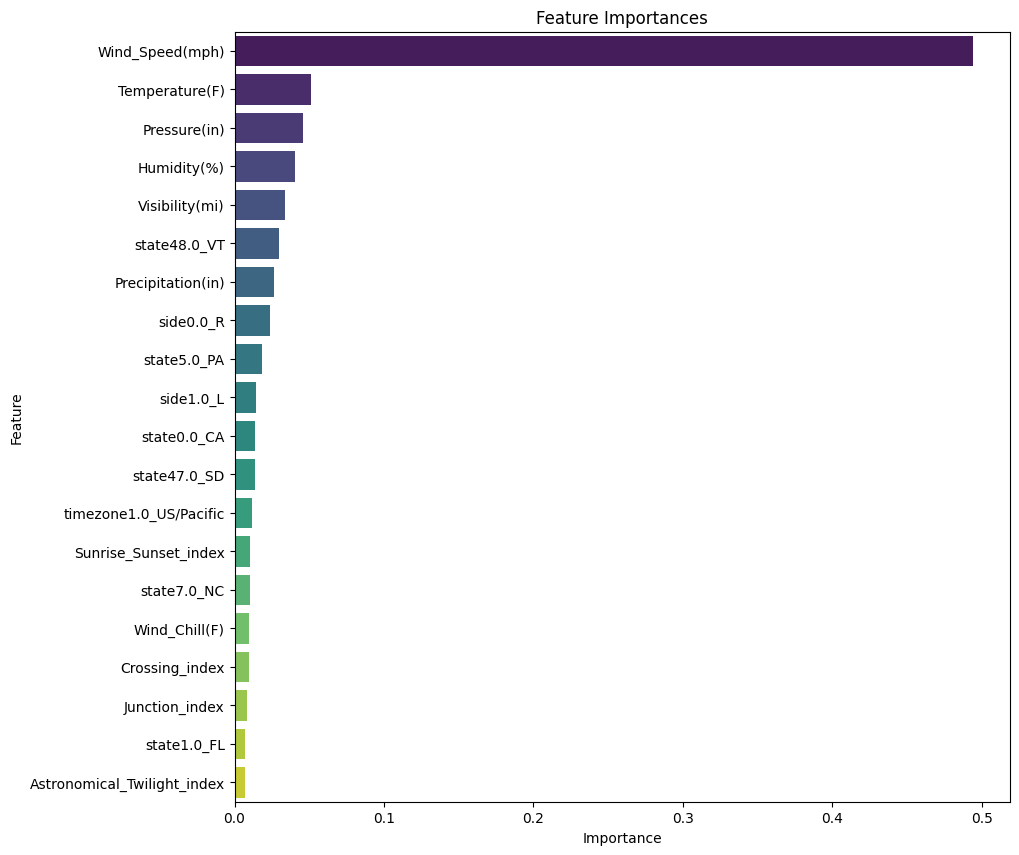

In [42]:
# visualize the feature importance of the gradient boosting model
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data = sorted_gbt_importances_pd, palette='viridis')
plt.title('Feature Importances')
plt.show()